In [305]:
import pandas as pd
import re
import matplotlib.pyplot as plt
from collections import defaultdict
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer

**California Department of Public Health CDPH**

**objetivo: relacionar tipos de productos, con sus ingresidentes con sospecha dañina**

In [306]:
df = pd.read_csv("chemicalcosmetics.csv")

In [307]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114635 entries, 0 to 114634
Data columns (total 23 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   _id                     114635 non-null  int64  
 1   CDPHId                  114635 non-null  int64  
 2   ProductName             114635 non-null  object 
 3   CSFId                   80662 non-null   float64
 4   CSF                     80237 non-null   object 
 5   CompanyId               114635 non-null  int64  
 6   CompanyName             114635 non-null  object 
 7   BrandName               114408 non-null  object 
 8   PrimaryCategoryId       114635 non-null  int64  
 9   PrimaryCategory         114635 non-null  object 
 10  SubCategoryId           114635 non-null  int64  
 11  SubCategory             114635 non-null  object 
 12  CasId                   114635 non-null  int64  
 13  CasNumber               108159 non-null  object 
 14  ChemicalId          

In [308]:
#CDPHId identificador del producto, puede aparecer más de una vez si el producto pertenece a más de una categoría o tiene más de un ingrediente posiblemente dañino
len(df["CDPHId"].unique())
#36 972 productos de una data de 114 K

36972

In [309]:
#df["CompanyName"].unique()
#solo para ver

**product name may contain misspelling or errors** ver eso  
csfiD cdph internal identification number for a color/scent/flavor  
CSF color/Scent or flavour sent by de manufactorer, may have errors, not all products has this  
Company name and id para identificar  
PrimaryCategory (13): nail products, hair care... interes: Sun-Related Products, Skin Care Products  

CasNumber, number asigned for a specific chemical, diferent types of one, may have diferente casnumber.  
ChemicalId: id registered in cdph  
chemicalName: chemical substances may have more than one chamicalname, "as ingredients known or suspected to cause cancer or developmental or reproductive harm".  

DiscontinuedDate, date the **product** was discontinued.  
importante  
ChemicalDateRemoved, date the **chemical** was removed from the product  
Chemical Count #based on current reporting, not count the removed ones: last update: October 2, 2023  





In [310]:
df.head()

,_id,CDPHId,ProductName,CSFId,CSF,CompanyId,CompanyName,BrandName,PrimaryCategoryId,PrimaryCategory,...,CasNumber,ChemicalId,ChemicalName,InitialDateReported,MostRecentDateReported,DiscontinuedDate,ChemicalCreatedAt,ChemicalUpdatedAt,ChemicalDateRemoved,ChemicalCount
0,1,2,ULTRA COLOR RICH EXTRA PLUMP LIPSTICK-ALL SHADES,NaN,NaN,4,New Avon LLC,AVON,44,Makeup Products (non-permanent),...,13463-67-7,6,Titanium dioxide,2009-06-17T00:00:00,2013-08-28T00:00:00,2011-02-01T00:00:00,2009-07-09T00:00:00,2009-07-09T00:00:00,NaN,1
1,2,3,Glover's Medicated Shampoo,NaN,NaN,338,J. Strickland & Co.,Glover's,18,Hair Care Products (non-coloring),...,65996-92-1,4,Distillates (coal tar),2009-07-01T00:00:00,2009-07-01T00:00:00,NaN,2009-07-01T00:00:00,2009-07-01T00:00:00,NaN,2
2,3,3,Glover's Medicated Shampoo,NaN,NaN,338,J. Strickland & Co.,Glover's,18,Hair Care Products (non-coloring),...,140-67-0,5,Estragole,2009-07-01T00:00:00,2009-07-01T00:00:00,NaN,2009-07-02T00:00:00,2009-07-02T00:00:00,NaN,2
3,4,4,PRECISION GLIMMER EYE LINER-ALL SHADES �,NaN,NaN,4,New Avon LLC,AVON,44,Makeup Products (non-permanent),...,13463-67-7,7,Titanium dioxide,2009-07-09T00:00:00,2013-08-28T00:00:00,NaN,2009-07-09T00:00:00,2009-07-09T00:00:00,NaN,1
4,5,5,AVON BRILLIANT SHINE LIP GLOSS-ALL SHADES �,NaN,NaN,4,New Avon LLC,AVON,44,Makeup Products (non-permanent),...,13463-67-7,8,Titanium dioxide,2009-07-09T00:00:00,2013-08-28T00:00:00,2011-02-01T00:00:00,2009-07-09T00:00:00,2009-07-09T00:00:00,NaN,1


In [311]:
#eliminar los que no tienen que ver con skincare, analizar los 13 tipos de productos
df["PrimaryCategory"].unique()
stay_categorys = ["Sun-Related Products", "Skin Care Products "]

In [312]:
#ver q entra dentro de maquillaje
df[df["PrimaryCategory"] == "Makeup Products (non-permanent)"]["SubCategory"].unique()

array(['Lip Color - Lipsticks, Liners, and Pencils',
       'Eyeliner/Eyebrow Pencils', 'Lip Gloss/Shine', 'Eye Shadow',
       'Mascara/Eyelash Products', 'Foundations and Bases',
       'Lip Balm (making a cosmetic claim)', 'Blushes ', 'Rouges',
       'Face Powders', 'Other Makeup Product', 'Makeup Fixatives',
       'Paints (e.g. facial, body)', 'Makeup Preparations'], dtype=object)

In [313]:
#ver q entra dentro de personal care products
df[df["PrimaryCategory"] == "Personal Care Products"]["SubCategory"].unique()
#no califica para skin care

array(['Hand Cleansers and Sanitizers', 'Douches',
       'Other Personal Care Product ', 'Feminine Deodorants',
       'Underarm Deodorants', 'Antiperspirants (making a cosmetic claim)',
       'Lubricants  (e.g. personal, sexual, massage oil)'], dtype=object)

In [314]:
#sun related
df[df["PrimaryCategory"] == "Sun-Related Products"]["SubCategory"].unique()
#solo resalta el bloqueador

array(['Sunscreen (making a cosmetic claim) ', 'Indoor Tanning Products',
       'Suntan Enhancers', 'Other Sun-Related Product'], dtype=object)

In [315]:
# stay categorys
df = df[df["PrimaryCategory"].isin(stay_categorys)]
#eliminar los que no sean bloqueador solar 'Indoor Tanning Products','Suntan Enhancers', 'Other Sun-Related Product'
stay_subcat = ["Sunscreen (making a cosmetic claim) ", ""]
df = df[~df["SubCategory"].isin(["Indoor Tanning Products","Suntan Enhancers", "Other Sun-Related Product", 'Powders (excluding aftershave, baby powder, and makeup face powder)', 'Depilatories', 'Sprays (excluding fragrances)','Foot Powders and Sprays'])]

In [316]:
len(df["CDPHId"].unique())
#de 36k a 1.4k productos ahora si relacionados al skin care

6196

In [317]:
df.info()
#remarcar atributos importantes y ver cual tienen nulos, cdphid, primary y sub category,  chemical name and id, chemical count

<class 'pandas.core.frame.DataFrame'>
Index: 11992 entries, 36 to 114622
Data columns (total 23 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   _id                     11992 non-null  int64  
 1   CDPHId                  11992 non-null  int64  
 2   ProductName             11992 non-null  object 
 3   CSFId                   4870 non-null   float64
 4   CSF                     4867 non-null   object 
 5   CompanyId               11992 non-null  int64  
 6   CompanyName             11992 non-null  object 
 7   BrandName               11918 non-null  object 
 8   PrimaryCategoryId       11992 non-null  int64  
 9   PrimaryCategory         11992 non-null  object 
 10  SubCategoryId           11992 non-null  int64  
 11  SubCategory             11992 non-null  object 
 12  CasId                   11992 non-null  int64  
 13  CasNumber               10984 non-null  object 
 14  ChemicalId              11992 non-null  i

Missing Not At Random  

En este dataset los nulos se deben simplemente a que ese product no presenta una categoria por ejemplo, que no tienen fecha de discontinuo, sigue estando en el mercado, o no tiene casnumber, no todos los productos lo tienen, si bien refiere al químico, todos ya están registrados en ChemicalID y ChemicalName.  

In [318]:
#Agrupar quimicos posiblemente dañinos por tipos de products, ver en sub categorys y en name. Analizar también los productos q han eliminado el quimico, la fecha y los q no
#key words in product name, estandarizar nombres, tanto de productos como de los quimicos
print(df["ProductName"].unique())

["Aloe Up Lil' Kids SPF 45 Aloe Based Sunscreen Lotion"
 "Aloe Up Lil' Kids SPF 30+ Sunscreen Stick"
 'Aloe Up SPF 30 Sunscreen Stick' ... 'Hydrating Glitter Peel Off Mask'
 'Gingerbread Creamy Mud Mask' 'LIBERATTA PERFUMED CREAM']


In [319]:
df["SubCategory"].unique()

array(['Sunscreen (making a cosmetic claim) ',
       'Anti-Wrinkle/Anti-Aging Products (making a cosmetic claim)',
       'Skin Moisturizers (making a cosmetic claim)',
       'Acne Products (making a cosmetic claim)', 'Facial Masks',
       'Skin Astringent (making a cosmetic claim)',
       'Skin Bleaching (making a cosmetic claim) ', 'Skin Cleansers',
       'Skin Toner (making a cosmetic claim)', 'Nighttime Skin Care',
       'Other Skin Care Product', 'Skin Fresheners', 'Facial Cream'],
      dtype=object)

In [320]:
#df[df["SubCategory"]=="Facial Masks"]["ProductName"].unique()
#convertir tanto los nombres de los products y sus subcategoryas a lower para sacar más info
df["Clean_ProductName"] = df["ProductName"].str.lower()
df["Clean_SubCategory"] = df["SubCategory"].str.lower()

In [321]:
df["Clean_ProductName"] = [i.split(" ") for id,i in enumerate(df["Clean_ProductName"])]
df["Clean_SubCategory"] = [i.split(" ") for id,i in enumerate(df["Clean_SubCategory"])]

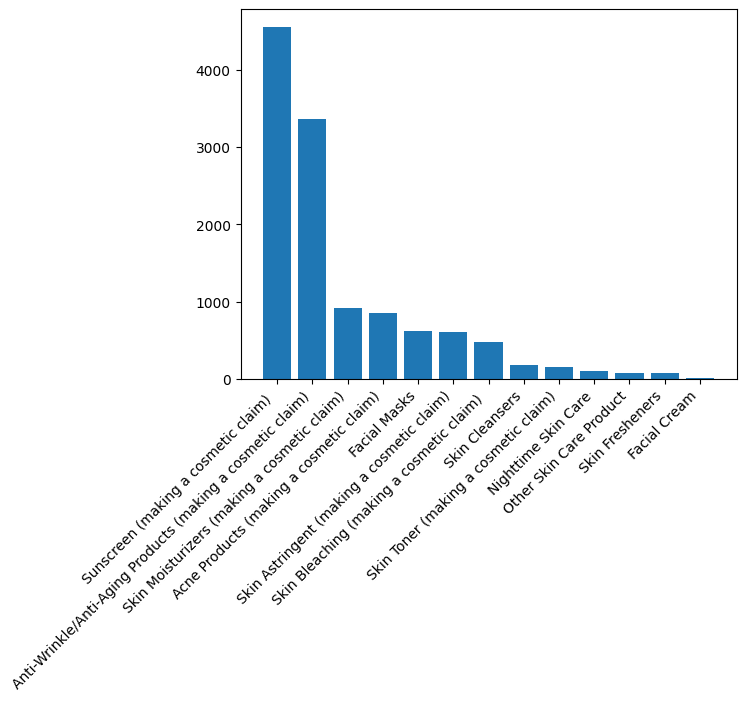

In [322]:
#como estan distribuidos los productos por categoria
plt.bar(df["SubCategory"].unique(), df["SubCategory"].value_counts())
plt.xticks(rotation=45, ha='right',fontsize=10 )
plt.show()

In [323]:
stopwords = ["&", "-", "/", "15", "20", "30", "25","45", "and", "with"]
df["Clean_ProductName"] = [[e for e in i if e not in stopwords] for id,i in enumerate(df["Clean_ProductName"])]

In [324]:
#import re
def clean_tokens(tokens):
    cleaned = []
    for token in tokens:
        # Separar letras de números (ej: "spf15" -> ["spf", "15"])
        separated = re.findall(r'([a-zA-Z]+|\d+)', token)
        cleaned.extend(separated)
    return cleaned

def remove_stopwords(tokens):
    stopwords = ["&", "-", "/", "15", "20", "30", "25","45", "and", "with"]
    t = [token for token in tokens if token.lower() not in stopwords]
    for id,i in enumerate(t):
      if i=="creme":
        t[id] ="cream"
      if i=="yeux":
        t[id] ="eye"
    return t

In [325]:
df["Clean_ProductName"] = df["Clean_ProductName"].transform(clean_tokens).transform(remove_stopwords)

In [326]:
facial_keywords = {"facial", "eye", "face", "under-eye", "eyebrow", "lash", "antiaging", "anti-aging" ,"anti-wrinkle"}
is_facial = df["Clean_ProductName"].apply(
    lambda tokens: any(token.lower() in facial_keywords for token in tokens if isinstance(token, str))
)
df_facial = df[is_facial].copy()


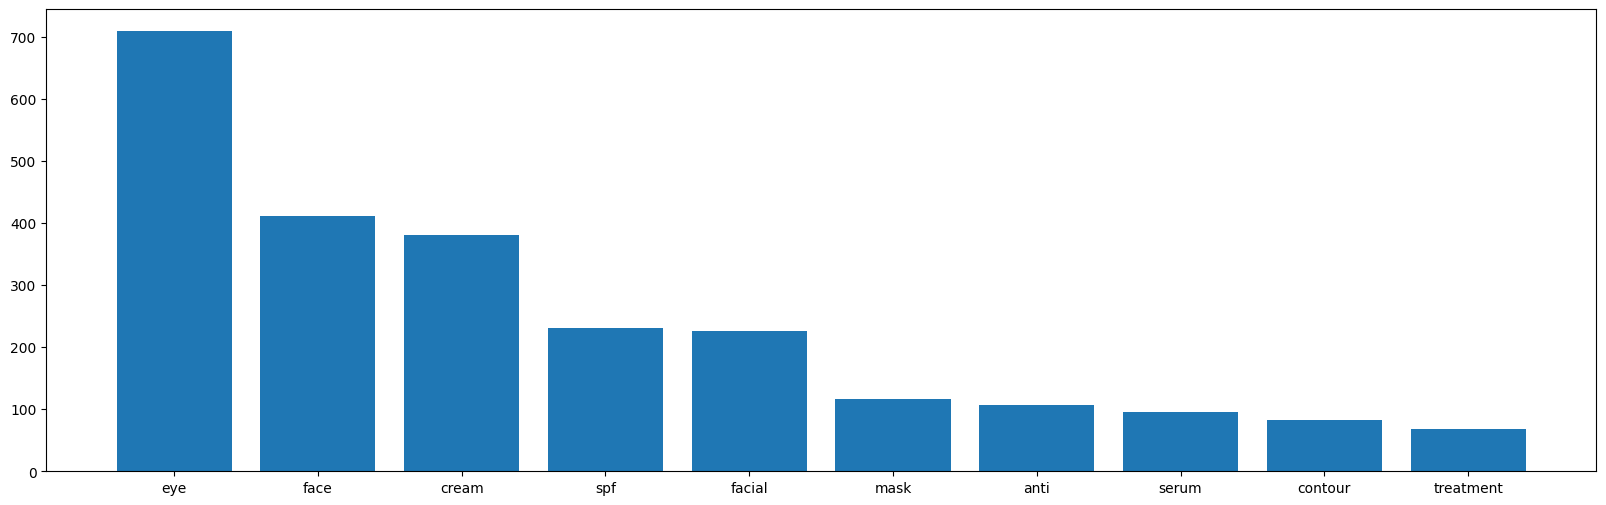

In [327]:
all_words = []
for name in df_facial["Clean_ProductName"]:
  all_words.extend(name)
word_counts = Counter(all_words)

moref_15 = word_counts.most_common(10)
df_moref = pd.DataFrame(moref_15, columns=["Palabra", "Frecuencia"])

plt.figure(figsize=(20, 6))
bars = plt.bar(df_moref["Palabra"], df_moref["Frecuencia"], color="#1f77b4")


manejar key words de nombres, por los que le den más información al producto, aplicando indices de tf-idf

In [328]:
tfidf = TfidfVectorizer(
    #limites para ignorar las palabras
    max_df=0.90,
    min_df=10,
    stop_words="english"
)
df_facial["Clean_Text"] = df_facial["Clean_ProductName"].apply(lambda tokens: " ".join(tokens))

tfidf_matrix = tfidf.fit_transform(df_facial["Clean_Text"])
feature_names = tfidf.get_feature_names_out()

def top_words_per_row(matrix, feature_names, n_top=6):
    top_words = []
    for row in matrix:
        sorted_indices = row.toarray().argsort()[0][-n_top:][::-1]
        top_words.append([feature_names[i] for i in sorted_indices])
    return top_words

df_facial["top_words"] = top_words_per_row(tfidf_matrix, feature_names)

In [329]:
df_facial["top_words"][50:100]

,top_words
6822,"[kiehl, tinted, ultra, sunscreen, moisturizer,..."
6823,"[kiehl, tinted, ultra, sunscreen, moisturizer,..."
6850,"[wash, facial, wrinkle, youth, worker, white]"
6851,"[wash, facial, wrinkle, youth, worker, white]"
6852,"[wash, facial, wrinkle, youth, worker, white]"
6853,"[total, wash, body, cleanser, face, worker]"
6960,"[lifting, wrinkle, firming, care, anti, face]"
7052,"[contour, des, eye, youth, white, wrinkles]"
7053,"[contour, des, eye, youth, white, wrinkles]"
7116,"[essence, eye, youth, wrinkles, white, wash]"


In [330]:
#preparar por grupos: wrinkels, acne, moisture cream, firming eye, anti aging, sunscreen, serum, clenaser, youth, spf, facial mask, moisturizer
categories = {
    "wrinkles": ["wrinkle","wrinkles",  "anti-wrinkle", "lines", "aging"],
    "acne": ["acne", "pimple", "breakout", "blemish", "salicylic"],
    "moisture_cream": ["moisture", "cream", "hydrating", "hydrat"],
    "firming_eye": ["firming", "eye", "contour", "dark circle"],
    "anti_aging": ["antiaging", "aging","anti-aging", "anti-age", "longevity", "age-defy"],
    "sunscreen": ["sunscreen", "sunblock", "spf", "uv", "sun protection"],
    "serum": ["serum", "concentrate", "essence"],
    "cleanser": ["cleanser", "wash", "foam", "cleansing"],
    "youth": ["youth", "young", "renewal", "rejuvenat"],
    "facial_mask": ["mask",],
    "moisturizer": ["moisturizer", "lotion"]
}

In [331]:
def assign_category(row):
    product_keywords = " ".join(row["top_words"] + row["Clean_ProductName"]).lower()
    assigned_categories = []

    for category, keywords in categories.items():
        if any(keyword in product_keywords for keyword in keywords):
            assigned_categories.append(category)

    return assigned_categories if assigned_categories else ["other"]

df_facial["category"] = df_facial.apply(assign_category, axis=1)

In [332]:
chemicals_by_category = defaultdict(list)
for _, row in df_facial.iterrows():
    if pd.notna(row["ChemicalName"]):
        for category in row["category"]:
            chemicals_by_category[category].append(row["ChemicalName"].lower())
dangerous_chemicals_report = {
    category: dict(pd.Series(chemicals).value_counts())
    for category, chemicals in chemicals_by_category.items()
}


In [333]:
dangerous_chemicals_report["wrinkles"]

{'titanium dioxide': np.int64(581),
 'vitamin a palmitate': np.int64(51),
 'retinol/retinyl esters, when in daily dosages in excess of 10,000 iu, or 3,000 retinol equivalents.': np.int64(36),
 'retinyl palmitate': np.int64(33),
 'triethanolamine': np.int64(23),
 'cocamide diethanolamine': np.int64(17),
 'caffeine': np.int64(15),
 'silica, crystalline (airborne particles of respirable size)': np.int64(14),
 'retinol': np.int64(14),
 'benzophenone': np.int64(14),
 'ginkgo biloba extract': np.int64(10),
 'mineral oils, untreated and mildly treated': np.int64(9),
 'butylated hydroxyanisole': np.int64(8),
 'methyleugenol': np.int64(6),
 'aloe vera, whole leaf extract': np.int64(6),
 'coffea arabica extract': np.int64(6),
 'trade secret': np.int64(5),
 'mica': np.int64(4),
 'coffee': np.int64(4),
 'estragole': np.int64(3),
 'vitamin a': np.int64(3),
 'aloe vera, non-decolorized whole leaf extract': np.int64(2),
 'titanium dioxide (airborne, unbound particles of respirable size)': np.int64(2)

In [334]:
chemical_rename = {
    'retinol/retinyl esters, when in daily dosages in excess of 10,000 iu, or 3,000 retinol equivalents.': 'retinil/retinyl high dosages'
}

key_to_check = list(chemical_rename.keys())[0]

for category in dangerous_chemicals_report:
    if key_to_check in dangerous_chemicals_report[category]:
        dangerous_chemicals_report[category][chemical_rename[key_to_check]] = dangerous_chemicals_report[category].pop(key_to_check)

Con "Broad Spectrum": Protección completa contra:
Quemaduras solares (UVB).
Arrugas, flacidez y manchas (UVA).
Riesgo de cáncer de piel (ambos tipos).

In [335]:
import numpy as np
import matplotlib.colors as mcolors
import colorsys
def generate_pastel_palette(n_colors=500, hue_range=(0.6, 0.8), saturation=0.5, lightness=0.9):
    """Genera colores pasteles en tonos morados/lilas/azules."""
    hues = np.linspace(hue_range[0], hue_range[1], n_colors)  # Rango de tonos (0.6-0.8 = morado-azul)
    hsl_colors = [(h, saturation, lightness) for h in hues]
    hex_colors = [f"#{int(h[0]*255):02x}{int(h[1]*255):02x}{int(h[2]*255):02x}" for h in
                  [colorsys.hls_to_rgb(h, l, s) for (h, s, l) in hsl_colors]]
    return hex_colors

pastel_palette = generate_pastel_palette(500)

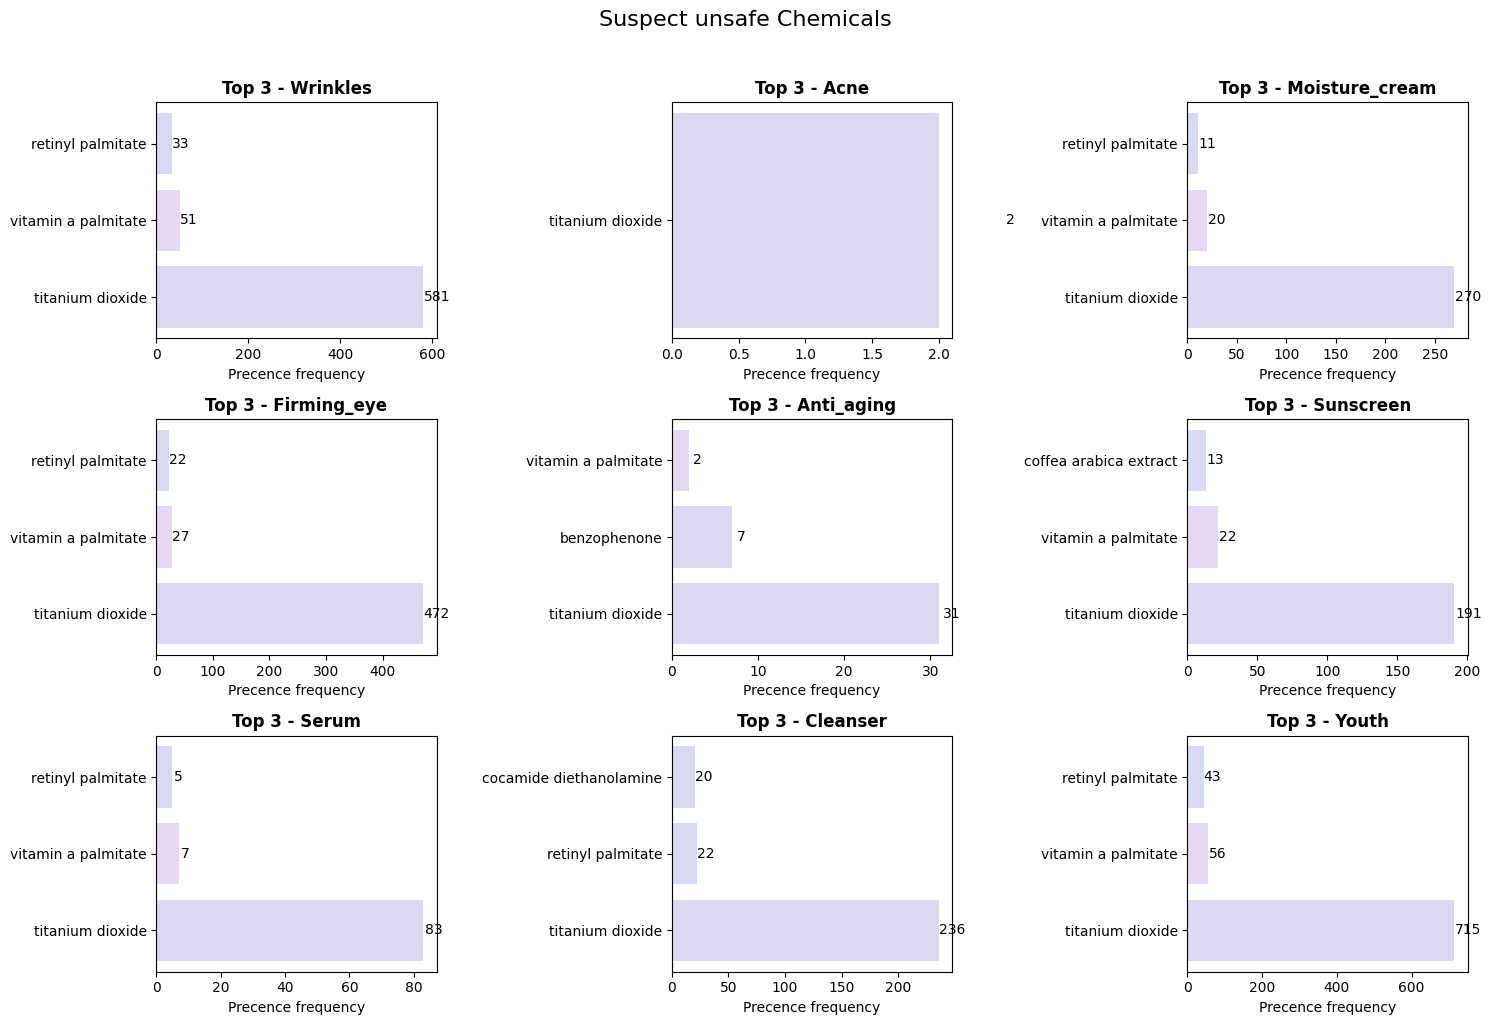

In [336]:

#categories = list(dangerous_chemicals_report.keys())
plt.figure(figsize=(15, 10))
import hashlib
def color_for_chemical(chemical_name, palette):
    hash_idx = int(hashlib.md5(chemical_name.encode()).hexdigest(), 16) % len(palette)
    return palette[hash_idx]


for i, category in enumerate(list(categories.keys())[:9], 1):
    plt.subplot(3, 3, i)
    chemicals = list(dangerous_chemicals_report[category].keys())[:3]
    counts = list(dangerous_chemicals_report[category].values())[:3]
    colors = [color_for_chemical(chem, pastel_palette) for chem in chemicals]
    bars = plt.barh(chemicals, counts, color=colors)
    plt.title(f'Top 3 - {category.capitalize()}', fontweight='bold')
    plt.xlabel('Precence frequency')

    # Añadir etiquetas de valor
    for bar in bars:
        width = bar.get_width()
        plt.text(width + 0.5, bar.get_y() + bar.get_height()/2,
                f'{int(width)}',
                ha='left', va='center')

# 4. Ajustes globales
plt.suptitle('Suspect unsafe Chemicals', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

¿algunos de los quimicos han sido sacado de los productos de interés en df_facial?

In [337]:
df_facial["ChemicalDateRemoved"].unique()

array([nan, '2009-09-17T00:00:00', '2009-10-01T00:00:00',
       '2010-12-01T00:00:00', '2010-12-17T00:00:00',
       '2010-12-24T00:00:00', '2012-01-10T00:00:00',
       '2009-10-12T00:00:00', '2009-10-14T00:00:00',
       '2009-10-19T00:00:00', '2013-12-31T00:00:00',
       '2009-10-16T00:00:00', '2009-12-08T00:00:00',
       '2010-01-06T00:00:00', '2011-04-01T00:00:00',
       '2010-06-22T00:00:00', '2010-06-23T00:00:00',
       '2010-10-04T00:00:00', '2011-09-05T00:00:00',
       '2011-09-23T00:00:00', '2016-10-27T00:00:00',
       '2012-11-20T00:00:00', '2012-05-21T00:00:00',
       '2012-07-17T00:00:00', '2013-09-23T00:00:00',
       '2014-09-29T00:00:00', '2013-10-23T00:00:00',
       '2015-05-11T00:00:00', '2016-03-07T00:00:00',
       '2019-07-18T00:00:00', '2020-03-03T00:00:00',
       '2020-03-20T00:00:00'], dtype=object)

In [338]:
def clean_date(d):
    d = d[0:10]
    return d


In [339]:
#df_facial = df_facial.dropna(subset=["ChemicalDateRemoved"])
df_facial["ChemicalDateRemoved"]=df_facial["ChemicalDateRemoved"].astype(str)
df_facial["ChemicalDateRemoved"] = df_facial["ChemicalDateRemoved"].apply(clean_date)

In [340]:
df_facial["ChemicalDateRemoved"].unique()

array(['nan', '2009-09-17', '2009-10-01', '2010-12-01', '2010-12-17',
       '2010-12-24', '2012-01-10', '2009-10-12', '2009-10-14',
       '2009-10-19', '2013-12-31', '2009-10-16', '2009-12-08',
       '2010-01-06', '2011-04-01', '2010-06-22', '2010-06-23',
       '2010-10-04', '2011-09-05', '2011-09-23', '2016-10-27',
       '2012-11-20', '2012-05-21', '2012-07-17', '2013-09-23',
       '2014-09-29', '2013-10-23', '2015-05-11', '2016-03-07',
       '2019-07-18', '2020-03-03', '2020-03-20'], dtype=object)

<ipython-input-351-703013bbcf9a>:23: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


<Figure size 1000x800 with 0 Axes>

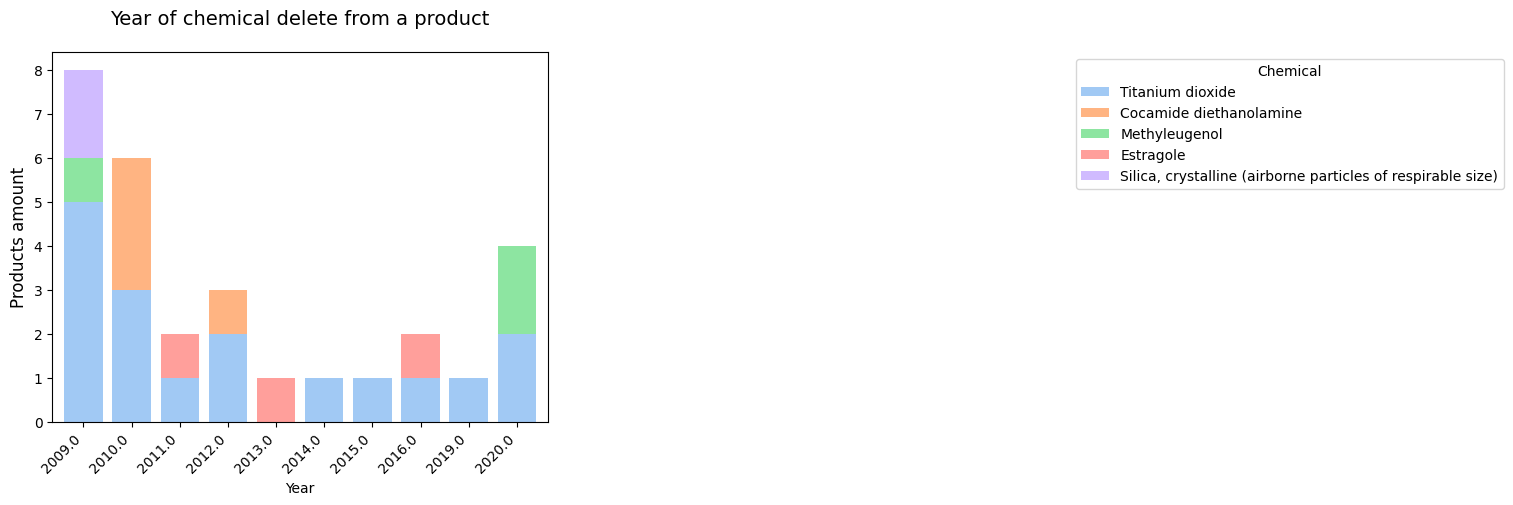

In [351]:
import seaborn as sns

df_facial['Year'] = pd.to_datetime(df_facial['ChemicalDateRemoved'], errors='coerce').dt.year


df_clean = df_facial.dropna(subset=['Year', 'ChemicalName'])
chem_by_year = df_clean.groupby(['Year', 'ChemicalName']).size().unstack(fill_value=0)

top_chemicals = df_clean['ChemicalName'].value_counts().nlargest(5).index
chem_by_year = chem_by_year[top_chemicals]

plt.figure(figsize=(10, 8))
colors = sns.color_palette("pastel")
chem_by_year.plot(kind='bar', stacked=True, color=colors, width=0.8)


plt.title('Year of chemical delete from a product', fontsize=14, pad=20)
plt.xlabel('Year', fontsize=10)
plt.ylabel('Products amount', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Chemical', bbox_to_anchor=(2.05, 1), loc='upper left')

plt.tight_layout()
plt.show()